In [165]:
%load_ext autoreload
%autoreload 2
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import signature.tensor_algebra as ta
from signature.ode_integration import *

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color= ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
trunc = 5
t = jnp.array(1)
esig = ta.expected_bm_signature(t=t, trunc=trunc).subsequence((0,))

print(esig)

1.0*0 + 1.0*1 + 0.5*11 + 0.5*22 + 0.16666666666666666*111 + 0.25*122 + 0.25*221 + 0.041666666666666664*1111 + 0.08333333333333333*1122 + 0.08333333333333333*1221 + 0.08333333333333333*2211 + 0.125*2222 + 0.008333333333333333*11111 + 0.020833333333333332*11122 + 0.020833333333333332*11221 + 0.020833333333333332*12211 + 0.041666666666666664*12222 + 0.020833333333333332*22111 + 0.041666666666666664*22122 + 0.041666666666666664*22221


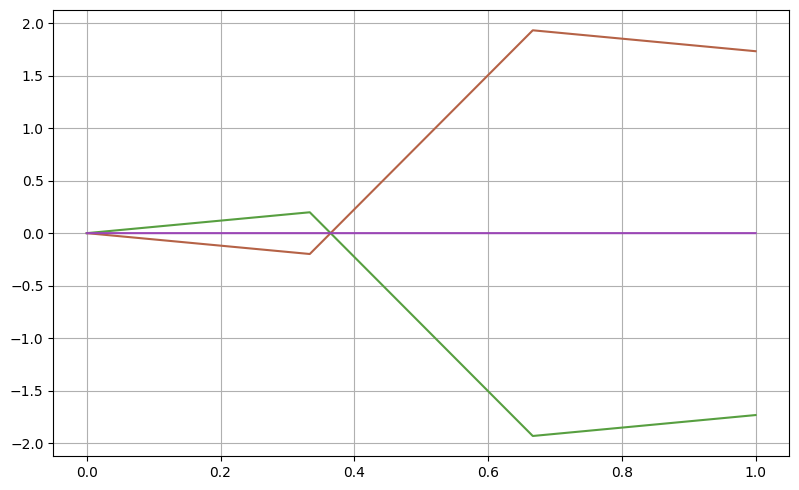

In [76]:
t = np.linspace(0, 1, 10000)

omega1 = ((t <= 1 / 3) * 0.5 * (4 - np.sqrt(22)) * t +
          (t > 1 / 3) * (t <= 2 / 3) * ((4 - np.sqrt(22)) / 6 + (-1 + np.sqrt(22)) * (t - 1 / 3)) +
          (t > 2 / 3) * ((2 + np.sqrt(22)) / 6 + 0.5 * (4 - np.sqrt(22)) * (t - 2 / 3)))

plt.plot(t, omega1 * np.sqrt(3))
plt.plot(t, -omega1 * np.sqrt(3))
plt.plot(t, np.zeros_like(t))

In [166]:
# chad order 5 cubature
K = 12
dT = 1 / K

e = ta.AlgebraBasis(dim=2, trunc=trunc)
v11 = e[1] * dT + e[2] * np.sqrt(3) / 2 * (4 - np.sqrt(22)) * np.sqrt(dT)
v12 = e[1] * dT + e[2] * np.sqrt(3) * (-1 + np.sqrt(22)) * np.sqrt(dT)

v21 = e[1] * dT + e[2] * np.sqrt(3) / 2 * (4 - np.sqrt(22)) * (-1) * np.sqrt(dT)
v22 = e[1] * dT + e[2] * np.sqrt(3) * (-1 + np.sqrt(22)) * (-1) * np.sqrt(dT)

sig_v11 = ta.tensor_exp(v11 / 3)
sig_v12 = ta.tensor_exp(v12 / 3)
sig_1 = ta.tensor_prod(
    ta.tensor_prod(sig_v11, sig_v12),
    sig_v11
)

sig_v21 = ta.tensor_exp(v21 / 3)
sig_v22 = ta.tensor_exp(v22 / 3)
sig_2 = ta.tensor_prod(
    ta.tensor_prod(sig_v21, sig_v22),
    sig_v21
)

sig_3 = ta.tensor_exp(e[1] * dT)

p1, p2, p3 = 1 / 6, 1 / 6, 2 / 3

cubature_mean = sig_1 * p1 + sig_2 * p2 + sig_3 * p3

In [172]:
# simple binomial tree
K_tree = 32
dT = 1 / K_tree

e = ta.AlgebraBasis(dim=2, trunc=trunc)
v_up = e[1] * dT + e[2] * np.sqrt(dT)
v_down = e[1] * dT + e[2] * np.sqrt(dT) * (-1)

sig_up = ta.tensor_exp(v_up)
sig_down = ta.tensor_exp(v_down)

cubature_mean_tree = sig_up * 0.5 + sig_down * 0.5

In [168]:
3**12

531441

In [169]:
np.log2(3**20)

31.699250014423125

In [173]:
print(ta.tensor_pow(cubature_mean, K) - esig)

-0.00017299484052368808*1122 + 5.663782919539975e-05*1212 + 0.0002893518518517907*1221 + -5.66378291953999e-05*2112 + 5.663782919539976e-05*2121 + -0.00017299484052368808*2211 + -8.601924403270345e-05*11122 + 2.6947340098566244e-05*11212 + 5.8103726503104525e-05*11221 + -2.7096898420541232e-05*12112 + 5.692512086662241e-05*12121 + 5.8103726503107994e-05*12211 + 0.00015580382122656194*12222 + -8.186191090148759e-07*21112 + -2.7096898420541236e-05*21121 + 2.6947340098566244e-05*21211 + -4.456231110787967e-05*21222 + -8.601924403269998e-05*22111 + -0.00022253375014263943*22122 + -4.456231110787969e-05*22212 + 0.00015580382122656888*22221


In [174]:
print(ta.tensor_pow(cubature_mean_tree, K_tree) - esig)

-0.002604166666666713*122 + 0.005208333333333334*212 + -0.002604166666666713*221 + -0.0013020833333333287*1122 + 0.002563476562500001*1212 + -0.0025634765625*1221 + 4.069010416666667e-05*2112 + 0.0025634765625*2121 + -0.0013020833333333287*2211 + -0.0026041666666666158*2222 + -0.0004342397054036447*11122 + 0.0008474985758463542*11212 + -0.0008481343587239537*11221 + 1.9709269205729168e-05*12112 + 0.0008277893066406251*12121 + -0.0008481343587239537*12211 + -0.0019246419270833107*12222 + 1.9709269205729168e-05*21121 + 0.000847498575846354*21211 + 0.00126953125*21222 + -0.0004342397054036412*22111 + -0.001293945312499982*22122 + 0.00126953125*22212 + -0.0019246419270833107*22221
